In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())

Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%        1.000000           -0.901371           

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in PCC feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling',
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling',
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        CoExpression           PCC           PPI  Root10DaysSeedling  \
count  41110.000000  41110.000000  41110.000000        41110.000000   
mean       0.991997     -0.361737      0.914668           -0.522040   
std        0.089101      0.463979      0.279379            0.498568   
min        0.000000     -1.000000      0.000000           -1.000000   
25%        1.000000     -0.747963      1.000000           -0.901371   
50%        1.000000     -0.449089      1.000000           -0.663664   
75%        1.000000     -0.051646      1.000000           -0.378497   
max        1.000000      1.000000      1.000000            1.000000   

       Leaf21DaysSeedling  Leaf45DaysOldPlant  log_2FoldChange            ET  \
count        41110.000000        41110.000000     41110.000000  41110.000000   
mean            -0.828778           -0.585144        -0.037332      1.407395   
std              0.327542            0.399046         0.39

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

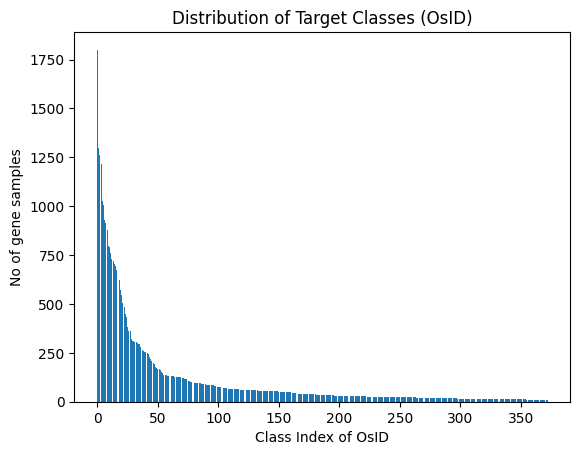

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=100, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

Number of input features: 1
Fold: 1
Epoch 1/100
1846/1846 [==============================] - 19s 8ms/step - loss: 5.0719 - accuracy: 0.0423 - val_loss: 5.0052 - val_accuracy: 0.0451
Epoch 2/100
1846/1846 [==============================] - 16s 8ms/step - loss: 4.9418 - accuracy: 0.0453 - val_loss: 4.9981 - val_accuracy: 0.0451
Epoch 3/100
1846/1846 [==============================] - 11s 6ms/step - loss: 4.9317 - accuracy: 0.0451 - val_loss: 5.0016 - val_accuracy: 0.0451
Epoch 4/100
1846/1846 [==============================] - 11s 6ms/step - loss: 4.9303 - accuracy: 0.0449 - val_loss: 5.0004 - val_accuracy: 0.0451
Epoch 5/100
1846/1846 [==============================] - 16s 9ms/step - loss: 4.9283 - accuracy: 0.0454 - val_loss: 5.0021 - val_accuracy: 0.0451
Epoch 6/100
1846/1846 [==============================] - 20s 11ms/step - loss: 4.9260 - accuracy: 0.0454 - val_loss: 5.0019 - val_accuracy: 0.0451
Epoch 7/100
1846/1846 [==============================] - 21s 11ms/step - loss: 4.9249 -

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 4ms/step - loss: 5.0696 - accuracy: 0.0437 - val_loss: 4.9998 - val_accuracy: 0.0557
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9016 - accuracy: 0.0540 - val_loss: 4.9468 - val_accuracy: 0.0521
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8553 - accuracy: 0.0542 - val_loss: 4.9177 - val_accuracy: 0.0530
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8265 - accuracy: 0.0566 - val_loss: 4.8973 - val_accuracy: 0.0585
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 4.8034 - accuracy: 0.0564 - val_loss: 4.8988 - val_accuracy: 0.0539
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 4.7819 - accuracy: 0.0618 - val_loss: 4.8995 - val_accuracy: 0.0660
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.7635 - accuracy: 0.0608 - val_loss: 4.8859 - val_a

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 11s 4ms/step - loss: 4.9310 - accuracy: 0.0700 - val_loss: 4.7653 - val_accuracy: 0.0785
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.6311 - accuracy: 0.0857 - val_loss: 4.6861 - val_accuracy: 0.0785
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5745 - accuracy: 0.0845 - val_loss: 4.6700 - val_accuracy: 0.0772
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 4.5453 - accuracy: 0.0834 - val_loss: 4.6559 - val_accuracy: 0.0774
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5252 - accuracy: 0.0843 - val_loss: 4.6429 - val_accuracy: 0.0744
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.5071 - accuracy: 0.0864 - val_loss: 4.6432 - val_accuracy: 0.0748
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 4.4901 - accuracy: 0.0868 - val_loss: 4.6418 - val_a

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 10s 4ms/step - loss: 4.4817 - accuracy: 0.1166 - val_loss: 4.0143 - val_accuracy: 0.1571
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6003 - accuracy: 0.2038 - val_loss: 3.4935 - val_accuracy: 0.2299
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1195 - accuracy: 0.2781 - val_loss: 3.1281 - val_accuracy: 0.2590
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8054 - accuracy: 0.3194 - val_loss: 2.8751 - val_accuracy: 0.3311
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5929 - accuracy: 0.3500 - val_loss: 2.7366 - val_accuracy: 0.3655
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4516 - accuracy: 0.3797 - val_loss: 2.6507 - val_accuracy: 0.3868
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3442 - accuracy: 0.3994 - val_loss: 2.6190 - val_a

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 8s 3ms/step - loss: 4.3818 - accuracy: 0.1421 - val_loss: 3.8444 - val_accuracy: 0.2090
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.2938 - accuracy: 0.2764 - val_loss: 3.1281 - val_accuracy: 0.3065
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6280 - accuracy: 0.3760 - val_loss: 2.5604 - val_accuracy: 0.4328
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1787 - accuracy: 0.4401 - val_loss: 2.2652 - val_accuracy: 0.4592
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8818 - accuracy: 0.4928 - val_loss: 2.0718 - val_accuracy: 0.4834
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6849 - accuracy: 0.5325 - val_loss: 1.8656 - val_accuracy: 0.5659
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5367 - accuracy: 0.5690 - val_loss: 1.7554 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 4.2252 - accuracy: 0.1851 - val_loss: 3.4835 - val_accuracy: 0.3133
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7629 - accuracy: 0.4194 - val_loss: 2.4936 - val_accuracy: 0.4926
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9665 - accuracy: 0.5559 - val_loss: 1.9440 - val_accuracy: 0.6099
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4968 - accuracy: 0.6476 - val_loss: 1.6554 - val_accuracy: 0.6829
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2136 - accuracy: 0.6991 - val_loss: 1.5473 - val_accuracy: 0.6471
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0420 - accuracy: 0.7330 - val_loss: 1.3079 - val_accuracy: 0.7109
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9156 - accuracy: 0.7514 - val_loss: 1.1499 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 4.1163 - accuracy: 0.2052 - val_loss: 3.2724 - val_accuracy: 0.3679
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4901 - accuracy: 0.4746 - val_loss: 2.2554 - val_accuracy: 0.5716
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7083 - accuracy: 0.6064 - val_loss: 1.7326 - val_accuracy: 0.6176
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2996 - accuracy: 0.6786 - val_loss: 1.4006 - val_accuracy: 0.7052
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0305 - accuracy: 0.7318 - val_loss: 1.1905 - val_accuracy: 0.7505
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8508 - accuracy: 0.7678 - val_loss: 1.0630 - val_accuracy: 0.7681
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7415 - accuracy: 0.7940 - val_loss: 0.9581 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 3.7981 - accuracy: 0.2305 - val_loss: 3.0205 - val_accuracy: 0.3683
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3642 - accuracy: 0.4831 - val_loss: 2.2126 - val_accuracy: 0.5329
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7212 - accuracy: 0.6078 - val_loss: 1.7779 - val_accuracy: 0.6486
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3432 - accuracy: 0.6750 - val_loss: 1.4869 - val_accuracy: 0.7096
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1078 - accuracy: 0.7134 - val_loss: 1.3240 - val_accuracy: 0.7294
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9652 - accuracy: 0.7347 - val_loss: 1.2120 - val_accuracy: 0.7459
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8597 - accuracy: 0.7596 - val_loss: 1.1794 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 3.9071 - accuracy: 0.2362 - val_loss: 2.8845 - val_accuracy: 0.4422
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0969 - accuracy: 0.5870 - val_loss: 1.8332 - val_accuracy: 0.6717
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3087 - accuracy: 0.7307 - val_loss: 1.3391 - val_accuracy: 0.7520
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9240 - accuracy: 0.7924 - val_loss: 1.0400 - val_accuracy: 0.8081
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6935 - accuracy: 0.8393 - val_loss: 0.8380 - val_accuracy: 0.8480
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5532 - accuracy: 0.8646 - val_loss: 0.7531 - val_accuracy: 0.8486
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 0.4727 - accuracy: 0.8760 - val_loss: 0.6880 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 3.7443 - accuracy: 0.2740 - val_loss: 2.6427 - val_accuracy: 0.5443
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8205 - accuracy: 0.6472 - val_loss: 1.5397 - val_accuracy: 0.7457
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0659 - accuracy: 0.7864 - val_loss: 1.0599 - val_accuracy: 0.8134
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6963 - accuracy: 0.8584 - val_loss: 0.8364 - val_accuracy: 0.8416
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4933 - accuracy: 0.8922 - val_loss: 0.6521 - val_accuracy: 0.8880
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3659 - accuracy: 0.9130 - val_loss: 0.5635 - val_accuracy: 0.9118
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3093 - accuracy: 0.9264 - val_loss: 0.5299 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 3.6240 - accuracy: 0.3070 - val_loss: 2.3019 - val_accuracy: 0.6207
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4837 - accuracy: 0.7251 - val_loss: 1.2874 - val_accuracy: 0.7943
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8269 - accuracy: 0.8348 - val_loss: 0.9037 - val_accuracy: 0.8418
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5496 - accuracy: 0.8778 - val_loss: 0.7410 - val_accuracy: 0.8796
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4141 - accuracy: 0.9042 - val_loss: 0.6196 - val_accuracy: 0.9034
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3373 - accuracy: 0.9178 - val_loss: 0.5259 - val_accuracy: 0.9188
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2873 - accuracy: 0.9278 - val_loss: 0.5169 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 3.7055 - accuracy: 0.3085 - val_loss: 2.4607 - val_accuracy: 0.5613
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6694 - accuracy: 0.6918 - val_loss: 1.4909 - val_accuracy: 0.7294
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0037 - accuracy: 0.8070 - val_loss: 1.0689 - val_accuracy: 0.8262
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6925 - accuracy: 0.8560 - val_loss: 0.8198 - val_accuracy: 0.8598
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5057 - accuracy: 0.8891 - val_loss: 0.6856 - val_accuracy: 0.8836
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 0.3966 - accuracy: 0.9113 - val_loss: 0.6006 - val_accuracy: 0.8964
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3312 - accuracy: 0.9214 - val_loss: 0.5480 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 8s 3ms/step - loss: 3.5560 - accuracy: 0.3293 - val_loss: 2.2817 - val_accuracy: 0.5853
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4870 - accuracy: 0.7303 - val_loss: 1.2570 - val_accuracy: 0.7985
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8140 - accuracy: 0.8441 - val_loss: 0.8558 - val_accuracy: 0.8717
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5036 - accuracy: 0.8938 - val_loss: 0.6441 - val_accuracy: 0.8950
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3525 - accuracy: 0.9190 - val_loss: 0.5278 - val_accuracy: 0.9221
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2753 - accuracy: 0.9343 - val_loss: 0.4789 - val_accuracy: 0.9278
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2333 - accuracy: 0.9433 - val_loss: 0.4622 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 3.5401 - accuracy: 0.3200 - val_loss: 2.4334 - val_accuracy: 0.5872
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6322 - accuracy: 0.7109 - val_loss: 1.4108 - val_accuracy: 0.7927
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.9474 - accuracy: 0.8222 - val_loss: 1.0350 - val_accuracy: 0.8209
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6233 - accuracy: 0.8739 - val_loss: 0.7906 - val_accuracy: 0.8843
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4136 - accuracy: 0.9121 - val_loss: 0.6213 - val_accuracy: 0.9113
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3125 - accuracy: 0.9310 - val_loss: 0.5258 - val_accuracy: 0.9263
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2542 - accuracy: 0.9407 - val_loss: 0.4610 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 3.5676 - accuracy: 0.3338 - val_loss: 2.2809 - val_accuracy: 0.5831
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4896 - accuracy: 0.7213 - val_loss: 1.2427 - val_accuracy: 0.7806
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.8127 - accuracy: 0.8431 - val_loss: 0.8539 - val_accuracy: 0.8570
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5165 - accuracy: 0.8889 - val_loss: 0.6555 - val_accuracy: 0.8862
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3652 - accuracy: 0.9139 - val_loss: 0.5525 - val_accuracy: 0.9085
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2893 - accuracy: 0.9297 - val_loss: 0.4857 - val_accuracy: 0.9164
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2398 - accuracy: 0.9403 - val_loss: 0.4497 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 7s 3ms/step - loss: 3.4852 - accuracy: 0.3245 - val_loss: 2.2597 - val_accuracy: 0.6158
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5092 - accuracy: 0.7121 - val_loss: 1.2729 - val_accuracy: 0.7758
Epoch 3/100
1846/1846 [==============================] - 6s 3ms/step - loss: 0.8433 - accuracy: 0.8235 - val_loss: 0.8715 - val_accuracy: 0.8418
Epoch 4/100
1846/1846 [==============================] - 6s 3ms/step - loss: 0.5578 - accuracy: 0.8733 - val_loss: 0.6638 - val_accuracy: 0.8770
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4107 - accuracy: 0.8987 - val_loss: 0.5388 - val_accuracy: 0.9052
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3213 - accuracy: 0.9211 - val_loss: 0.4720 - val_accuracy: 0.9118
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2815 - accuracy: 0.9290 - val_loss: 0.4352 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 8s 3ms/step - loss: 3.3092 - accuracy: 0.3803 - val_loss: 2.0155 - val_accuracy: 0.6486
Epoch 2/100
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3351 - accuracy: 0.7451 - val_loss: 1.1615 - val_accuracy: 0.7754
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.7624 - accuracy: 0.8449 - val_loss: 0.8050 - val_accuracy: 0.8568
Epoch 4/100
1846/1846 [==============================] - 6s 3ms/step - loss: 0.4963 - accuracy: 0.8901 - val_loss: 0.6610 - val_accuracy: 0.8838
Epoch 5/100
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3671 - accuracy: 0.9118 - val_loss: 0.5500 - val_accuracy: 0.9076
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2975 - accuracy: 0.9263 - val_loss: 0.4945 - val_accuracy: 0.9151
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2609 - accuracy: 0.9357 - val_loss: 0.4744 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 6s 2ms/step - loss: 3.3624 - accuracy: 0.3599 - val_loss: 1.9511 - val_accuracy: 0.6229
Epoch 2/100
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2389 - accuracy: 0.7594 - val_loss: 1.0884 - val_accuracy: 0.8009
Epoch 3/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6989 - accuracy: 0.8501 - val_loss: 0.7680 - val_accuracy: 0.8744
Epoch 4/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4818 - accuracy: 0.8911 - val_loss: 0.6184 - val_accuracy: 0.8884
Epoch 5/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3761 - accuracy: 0.9095 - val_loss: 0.5514 - val_accuracy: 0.8957
Epoch 6/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3103 - accuracy: 0.9248 - val_loss: 0.4667 - val_accuracy: 0.9168
Epoch 7/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2750 - accuracy: 0.9306 - val_loss: 0.4629 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 5s 2ms/step - loss: 3.6308 - accuracy: 0.3047 - val_loss: 2.3362 - val_accuracy: 0.5954
Epoch 2/100
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5461 - accuracy: 0.7090 - val_loss: 1.2840 - val_accuracy: 0.7655
Epoch 3/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.8359 - accuracy: 0.8285 - val_loss: 0.9278 - val_accuracy: 0.8286
Epoch 4/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5383 - accuracy: 0.8789 - val_loss: 0.6627 - val_accuracy: 0.8755
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 0.3964 - accuracy: 0.9049 - val_loss: 0.5695 - val_accuracy: 0.9003
Epoch 6/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3188 - accuracy: 0.9204 - val_loss: 0.4856 - val_accuracy: 0.9144
Epoch 7/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2762 - accuracy: 0.9285 - val_loss: 0.4709 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 5s 2ms/step - loss: 3.3526 - accuracy: 0.3693 - val_loss: 2.0667 - val_accuracy: 0.6141
Epoch 2/100
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3515 - accuracy: 0.7465 - val_loss: 1.1015 - val_accuracy: 0.8064
Epoch 3/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.7100 - accuracy: 0.8517 - val_loss: 0.7034 - val_accuracy: 0.8664
Epoch 4/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4398 - accuracy: 0.8969 - val_loss: 0.5559 - val_accuracy: 0.8891
Epoch 5/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3202 - accuracy: 0.9212 - val_loss: 0.4699 - val_accuracy: 0.9138
Epoch 6/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2631 - accuracy: 0.9342 - val_loss: 0.4481 - val_accuracy: 0.9118
Epoch 7/100
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2237 - accuracy: 0.9421 - val_loss: 0.3732 - val_ac

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

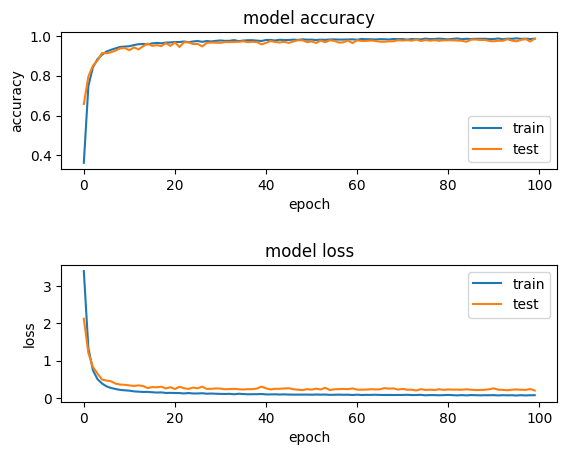

Final Test Accuracy: 0.9898282885551453


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.98      1.00      0.99       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         328              328        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True
